In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import nltk
import re
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
basepath = '/home/pcsor/facu/TP2/julian'
av_detalle = pd.read_csv(basepath + '/entrega6/fiuba_6_avisos_detalle.csv',low_memory=False)
av_navent = pd.read_csv(basepath + '/datos_navent_fiuba/fiuba_6_avisos_detalle.csv',low_memory=False)
av_test = pd.read_csv(basepath + '/test/fiuba_6_avisos_detalle.csv',low_memory=False)
av_missing = pd.read_csv(basepath + '/fiuba_6_avisos_detalle_missing_nivel_laboral.csv',low_memory=False)

#### Se cargan los 4 archivos para hacer el encoding

In [3]:
stopw = 'un,de,https,una,unas,unos,uno,sobre,todo,por,tambien,tras,otro,algun,alguno,alguna,algunos,algunas,ser,es,soy,eres,somos,sos,estoy,esta,estamos,estas,estan,como,en\
,para,atras,porque,por que,estado,estaba,ante,antes,siendo,ambos,pero,por,poder,puede,puedo,podemos,podes,pueden,fui,fue,fuimos,fueron,hacer,hago,hace,hacemos,haceis,hacen\
,cada,fin,incluso,primero,desde,ir,voy,va,vamos,vais,van,vaya,bueno,ha,tener,tengo,tiene,tenemos,teneis,tienen,el,la,lo,las,los,su,aqui,mio,tuyo,ellos,ellas,nos,nosotros\
,vosotros,vosotras,si,dentro,solo,solamente,ultimo,largo,haces,usted,ustedes,muchos,aquellos,aquellas,sus,entonces,cierto,ciertos,cierta,ciertas,intentar,intento,intenta,intentas\
,intentais,intentan,dos,bajo,arriba,encima,usar,uso,usas,usa,usamos,usais,usan,emplear,empleo,empleas,emplean,ampleamos,empleais,valor,muy,eras,eramos,eran,modo,bien,cual\
,cuando,donde,mientras,quien,con,entre,sin,podria,podrias,podriamos,podrian,podriais,yo,aquel,intentamos,ev,busqueda,ingresar,queres,haciendo,importante,encuentra\
,encontramos,debe,argentina,nuestro,ubicada,inscribirse,se,in,est,anos,NaN'
stopw = stopw.split(',')

#### Se sacan las stopwords

In [4]:
av_detalle = pd.concat([av_detalle,av_navent,av_test,av_missing])

#### se juntan los cuatro archivos de avisos

In [5]:
av_detalle = av_detalle.drop_duplicates('idaviso')

In [6]:
av_detalle.shape

(25288, 11)

#### Se limpian las descripciones y los titulos de los avisos, 
#### luego se le aplica TFIDF y se reduce la cantidad de dimensiones con SVD

In [7]:
descrip = av_detalle[['idaviso','descripcion','titulo']]

In [8]:
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: re.sub('<.*?>', '', s)) #####saco todo lo que sea codigo HTML
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: re.sub(r'[^\w]', ' ', s)) ##### saco todo lo que no sea alfanumerico
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: s.lower()) ###### lo paso a minuscula
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: unidecode.unidecode(s)) ####### saco los acentos
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: re.sub(r'\b\w{1,3}\b', '', s)) ###### remuevo las palabras cortas
descrip.loc[:,'descripcion'] = descrip['descripcion'].apply(lambda s: re.sub(' +',' ',s)) ###### remuevo los espacios en blanco de mas
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: s.lstrip()) ###### remuevo los espacios en blanco de mas
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: re.sub('<.*?>', '', s)) #####saco todo lo que sea codigo HTML
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: re.sub(r'[^\w]', ' ', s)) ##### saco todo lo que no sea alfanumerico
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: s.lower()) ###### lo paso a minuscula
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: unidecode.unidecode(s)) ####### saco los acentos
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: re.sub(r'\b\w{1,3}\b', '', s)) ###### remuevo las palabras cortas
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: re.sub(' +',' ',s)) ###### remuevo los espacios en blanco de mas
descrip.loc[:,'titulo'] = descrip['titulo'].apply(lambda s: s.lstrip()) ###### remuevo los espacios en blanco de mas

/home/pcsor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
tfidf = TfidfVectorizer(stop_words = stopw)
sparseM = tfidf.fit_transform(descrip['descripcion'])
sparseMT = tfidf.fit_transform(descrip['titulo'])
sparseMT.shape, sparseM.shape

#### se aplica TFIDF y se generan matrices dispersas que es el formato de entrada para la SVD

((25288, 5543), (25288, 54483))

In [10]:
conceptColumns = TruncatedSVD(n_components=100).fit_transform(sparseM) #### se utilizan 100 conceptos para las descripciones
conceptTitle = TruncatedSVD(n_components=30).fit_transform(sparseMT) #### se utilizan 50 conceptos para los titulos

In [11]:
conceptos = pd.DataFrame(conceptColumns)
titulos = pd.DataFrame(conceptTitle)
#textos = pd.concat([conceptos,titulos],axis=1,ignore_index=True)
textos=titulos.add_prefix('lsi')

In [12]:
av_detalle.reset_index(drop=True, inplace=True)

In [13]:
av_detalle.shape

(25288, 11)

In [14]:
av_detalle = pd.concat([av_detalle,textos],axis = 1)
av_detalle.shape

(25288, 41)

In [15]:
av_detalle[0:3]

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,...,lsi20,lsi21,lsi22,lsi23,lsi24,lsi25,lsi26,lsi27,lsi28,lsi29
0,1111556097,1,Responsable de Marketing-Producto Div. Constru...,<p>Buscamos un <strong>Responsable de Producto...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Desarrollo de Negocios,...,-0.008919,-0.058554,-0.131212,-0.055740,0.007099,0.027628,-0.044565,-0.072072,0.079433,0.101686
1,1111949392,1,Asesor de Servicios - Postventa Chevrolet,"<p><span style="""">Para nuestro cliente, conces...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Ingeniería Eléctrica y Electrónica,...,0.007907,-0.005394,-0.009168,0.003888,-0.038094,0.006068,0.055611,-0.032843,0.009237,0.020985
2,1112145935,1,Analistas de Impuestos Sr Ssr y Jr,<p>Importante Estudio de Auditoria y Consultor...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Impuestos,...,0.043371,0.010463,-0.088058,0.002131,0.035937,0.021144,0.031510,-0.032977,-0.033628,-0.112597


#### Se procede a encodear los features para trabajar con ML

In [16]:
lb_enc = LabelEncoder()
oh_enc = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [17]:
av_detalle = av_detalle.drop(['titulo','descripcion','idpais','ciudad','mapacalle','denominacion_empresa'],axis = 1)

* Area de trabajo

In [18]:
lista = av_detalle['nombre_area'].value_counts().sort_values(ascending = False)[0:30].keys().values
av_detalle['nombre_area'].loc[-(av_detalle['nombre_area'].isin(lista))]='Otro'
av_detalle['nombre_area'] = lb_enc.fit_transform(av_detalle['nombre_area'])
toconcat = oh_enc.fit_transform(av_detalle['nombre_area'])
toconcat = pd.DataFrame(toconcat)
av_detalle = pd.concat([av_detalle,toconcat.add_prefix('nombre_area')],axis=1)

/home/pcsor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


* Tipo de trabajo

In [19]:
av_detalle['tipo_de_trabajo'] = lb_enc.fit_transform(av_detalle['tipo_de_trabajo'])
toconcat = oh_enc.fit_transform(av_detalle['tipo_de_trabajo'])
toconcat = pd.DataFrame(toconcat)
av_detalle = pd.concat([av_detalle,toconcat.add_prefix('tipo_de_trabajo')],axis=1)

* Nombre zona

In [20]:
av_detalle['nombre_zona'].loc[av_detalle['nombre_zona'] == 'GBA Oeste'] = 'Gran Buenos Aires'
av_detalle['nombre_zona'].loc[av_detalle['nombre_zona'] == 'La Plata'] = 'Gran Buenos Aires'
av_detalle['nombre_zona'].loc[ (av_detalle['nombre_zona'] != 'Gran Buenos Aires') & (av_detalle['nombre_zona'] != 'Capital Federal') ] = 'Interior'

/home/pcsor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
av_detalle['nombre_zona'] = lb_enc.fit_transform(av_detalle['nombre_zona'])
toconcat = oh_enc.fit_transform(av_detalle['nombre_zona'])
toconcat = pd.DataFrame(toconcat)
av_detalle = pd.concat([av_detalle,toconcat.add_prefix('nombre_zona')],axis=1)
#### Para las zonas que no son Capital ni GBA se unifican en 'Interior'.

In [22]:
av_detalle = av_detalle.drop(['nombre_zona','tipo_de_trabajo','nombre_area'],axis=1)

#### Para el nivel laboral hay NaNs que se van a completar con Random Forest

In [23]:
av_detalle['nivel_laboral'].value_counts()

Senior / Semi-Senior                    16980
Junior                                   4149
Otro                                     1975
Jefe / Supervisor / Responsable          1527
Gerencia / Alta Gerencia / Dirección      322
Name: nivel_laboral, dtype: int64

In [24]:
av_train = av_detalle[ av_detalle['nivel_laboral'].notnull()]

In [25]:
av_train.shape,av_detalle.shape

((24953, 76), (25288, 76))

In [26]:
av_train_y = lb_enc.fit_transform(av_train['nivel_laboral'])

In [27]:
av_train.columns = av_train.columns.astype(str)

In [28]:
av_train = av_train.drop(['nivel_laboral'],axis = 1)

In [29]:
av_test = av_detalle[av_detalle['nivel_laboral'].isnull()]

In [30]:
av_test.shape

(335, 76)

In [31]:
av_test = av_test.drop(['nivel_laboral'],axis=1)

##### Se separan las rows con NaNs para hacer un DF 'test'
##### y se utilizan las rows con nivel_laboral conocido para precedir.

In [32]:
clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)

In [33]:
pd.Series(av_train_y).value_counts()

4    16980
2     4149
3     1975
1     1527
0      322
dtype: int64

In [34]:
pd.Series(av_train_y).mean()
#### se puede ver que el promedio es de 3.35

3.353103835210195

In [35]:
av_train[0:1]
#### se utilizan todos los features menos el ID

,idaviso,lsi0,lsi1,lsi2,lsi3,lsi4,lsi5,lsi6,lsi7,lsi8,...,tipo_de_trabajo3,tipo_de_trabajo4,tipo_de_trabajo5,tipo_de_trabajo6,tipo_de_trabajo7,tipo_de_trabajo8,tipo_de_trabajo9,nombre_zona0,nombre_zona1,nombre_zona2
0,1111556097,0.04062,-0.003149,0.041221,0.02969,-0.006336,-0.012014,-0.010472,-0.03835,0.067184,...,0,0,0,0,0,0,0,0,1,0


In [36]:
clf.fit(av_train.iloc[:,1:], av_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<Container object of 74 artists>

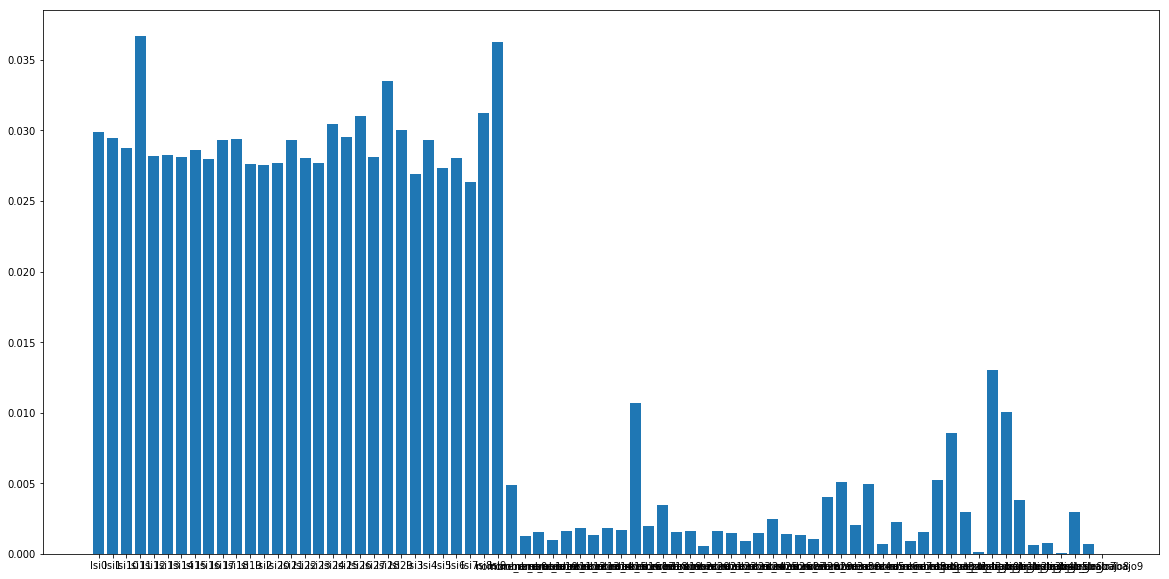

In [37]:
plt.figure(figsize=(20,10))
plt.bar(av_train.iloc[:,1:].columns.values,clf.feature_importances_)

In [38]:
predic = clf.predict(av_test.iloc[:,1:])

In [39]:
predic.mean()
#### se puede ver que el promedio de la prediccion es similar al promedio marcado en el train.
#### Hay una clara predominancia de 4
#### Tambien se puede apreciar que los primeros vectores (los mas importantes) 
#### de la SVD tienen importancia para la prediccion
#### (se puede ver en los picos, es donde justamente empiezan las descripciones y los titulos).

3.582089552238806

In [40]:
predic = pd.DataFrame(list(map(int, predic)))

In [41]:
predic.isnull().sum()

0    0
dtype: int64

In [42]:
av_test = av_test.reset_index().drop(['index'],axis=1)

In [43]:
av_test['nivel_laboral'] = predic

In [44]:
av_train['nivel_laboral'] = av_train_y

In [45]:
av_completo = pd.concat([av_test,av_train])

In [46]:
av_completo['nivel_laboral']

0        3
1        4
2        4
3        3
4        4
5        4
6        4
7        4
8        4
9        4
10       2
11       4
12       4
13       4
14       4
15       4
16       4
17       3
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       1
29       1
        ..
24923    4
24924    4
24925    4
24926    4
24927    4
24928    4
24929    4
24930    4
24931    4
24932    4
24933    4
24934    2
24935    2
24936    2
24937    2
24938    2
24939    4
24940    4
24941    4
24942    4
24943    4
24944    4
24945    2
24946    1
24947    4
24948    4
24949    4
24996    4
25076    4
25132    4
Name: nivel_laboral, Length: 25288, dtype: int64

In [47]:
toconcat = oh_enc.fit_transform(av_completo['nivel_laboral'])
toconcat = pd.DataFrame(toconcat)
av_detalle = pd.concat([av_detalle,toconcat.add_prefix('nivel_laboral')],axis=1)

In [48]:
av_detalle.to_csv(basepath + '/avisos.csv',index=False)